In [2]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Activation,Input,UpSampling2D,Lambda
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers
import cv2
from tqdm import tqdm
import random
import numpy as np
from tensorflow.keras.utils import Sequence
import random
from keras import backend as K
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import resnet

In [3]:
BATCH_SIZE=4
IMG_SIZE=299

In [4]:
import zipfile
with zipfile.ZipFile('../input/notebook36cfb71da3/database-full.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')
os.remove('./data/database-full/ image11396.jpg')
import shutil
shutil.rmtree('./data/__MACOSX')

In [5]:
def load_image_from_path(path):
    
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, size = (IMG_SIZE, IMG_SIZE))
    
    return image/255.

In [6]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [7]:
def get_mapk(K,similarities,retrieval):
    scores = []
    for predicted, actual in zip(similarities, retrievals):
        scores.append(mapk(actual, predicted, k=K))
    return scores

In [8]:

def sorting(tup, reverse=True):
    return(sorted(tup, key = lambda x: x[1],reverse=reverse))
#Obtiene las imagenes mas similares utilizando distancia euclideana
def get_most_similars(query, database):
    
    x2 = database[database.img_name == query].encoded.values[0]
    distances = []
    names = []
    for i, fila in database.iterrows():

        x1 = fila.encoded
        names.append(fila.img_name)
        distances.append(np.linalg.norm(x2-x1))
        
    distances = [(x,y) for x,y in zip(names, distances)]
    distances=sorting(distances,False)
        
    return np.array(distances)[:,0]

In [9]:
example = pd.read_csv('../input/taller3data/examples_of_retrieval.csv', sep="\t")
retrievals=[]
retrievals.append([x.replace(" ", "") for x in example.columns[0].split(",")])
for i in example.index:
    retrievals.append([x.replace(" ", "") for x in example.iloc[i].values[0].split(",")])

In [10]:
img_gen=ImageDataGenerator(rescale=1./255.)
img_data=img_gen.flow_from_directory('./data',shuffle=False,target_size=(299,299),class_mode='input',batch_size=BATCH_SIZE)
img_name=img_names=[x.split(' ')[1] for x in img_data.filenames]

Found 31783 images belonging to 1 classes.


# Modelo pre-entrenado InceptionResNetV2

In [ ]:
IncRes=tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=True, input_shape=(299, 299, 3))
model_1=Model(inputs=IncRes.input, outputs=IncRes.get_layer("avg_pool").output)

## Obteniendo representaciones de las imagenes

In [12]:
encoded_1=model_1.predict(img_data,verbose=1)

2022-07-27 15:08:41.905908: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-27 15:08:45.995515: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


7946/7946 [==============================] - 431s 53ms/step


2022-07-27 15:15:53.188950: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 195274752 exceeds 10% of free system memory.


In [13]:
encoded_df_1=pd.DataFrame({'encoded':[x for x in encoded_1],'img_name':img_names})

In [19]:
similarities_1 = []
for retrieval in tqdm(retrievals):
    query = retrieval[0]
    similarities_1.append(np.array(get_most_similars(query, encoded_df_1)[:101]))

100%|██████████| 100/100 [04:25<00:00,  2.66s/it]


In [20]:
most_sim_1=get_most_similars('image5876.jpg',encoded_df_1)

### Ejemplo de query

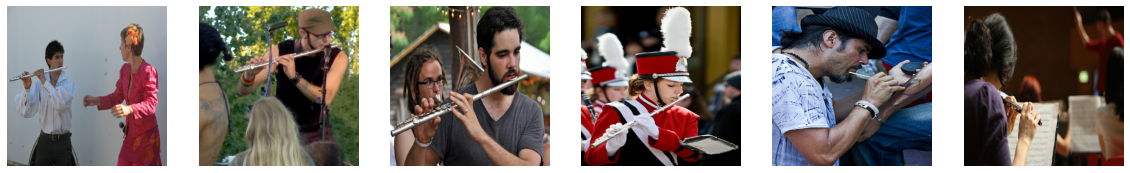

In [35]:
_, axs = plt.subplots(1, 6, figsize=(20, 15))
axs = axs.flatten()
for im, ax in zip(most_sim_1, axs):
    ax.imshow(load_image_from_path('data/database-full/ '+im))
    ax.axis('off')
plt.show()


# Modelo pre-entrenado Xception

In [ ]:
Xception=tf.keras.applications.Xception(weights="imagenet", include_top=True, input_shape=(299, 299, 3))
model_2=Model(inputs=Xception.input, outputs=Xception.get_layer("avg_pool").output)

In [37]:
encoded_2=model_2.predict(img_data,verbose=1)

7946/7946 [==============================] - 256s 32ms/step


2022-07-27 15:42:41.181591: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 260366336 exceeds 10% of free system memory.


In [38]:
encoded_df_2=pd.DataFrame({'encoded':[x for x in encoded_2],'img_name':img_names})

In [39]:
similarities_2 = []
for retrieval in tqdm(retrievals):
    query = retrieval[0]
    similarities_2.append(np.array(get_most_similars(query, encoded_df_2)[:101]))

100%|██████████| 100/100 [04:21<00:00,  2.62s/it]


In [40]:
most_sim_2=get_most_similars('image5876.jpg',encoded_df_2)

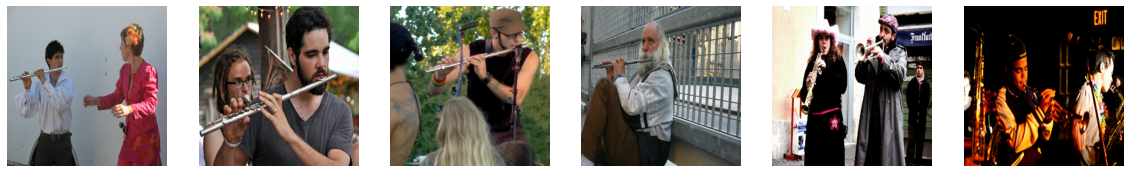

In [41]:
_, axs = plt.subplots(1, 6, figsize=(20, 15))
axs = axs.flatten()
for im, ax in zip(most_sim_2, axs):
    ax.imshow(load_image_from_path('data/database-full/ '+im))
    ax.axis('off')
plt.show()


In [42]:
#MAP100 score para InceptionResNetV2
np.mean(get_mapk(100,similarities_1[1:],retrievals))

0.6331391108833881

In [43]:
#MAP100 score para Xception
np.mean(get_mapk(100,similarities_2[1:],retrievals))

0.6350369246901727

### Submission

In [62]:
queries_test = pd.read_csv('../input/taller3data/names_test_queries.csv', sep="\t", header=None)
subm_similarities = []
for i, query_ in tqdm(queries_test.iterrows()):
    query = query_[0][1:]
    subm_similarities.append(np.array(get_most_similars(query, encoded_df_2)[1:101]))

861it [38:24,  2.68s/it]


In [63]:
final_sim=[]
for sim in subm_similarities:
    aux_l=[]
    for im in sim:
        aux_l.append(im[5:-4])
    final_sim.append(np.array(aux_l))
        

In [64]:
final = pd.DataFrame({'Id': [x[0][6:-4] for x in queries_test.values], 'Expected': [" ".join(x) for x in final_sim]})

In [65]:
final=final.set_index('Id')

In [66]:
final.to_csv('subm_xcept.csv')